In [3]:
!pip install tweepy

In [5]:
!pip install textblob

In [8]:

import tweepy
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer


In [9]:
# twitter app credentials
consumer_key = "xR6v2TTbqc2l6842FQ9AGKKdV" 
consumer_secret = "owPTwMwQq4j1fq98TGzS0tXGJByU00U6otUgVkQJLcLBhEE3FR"
access_key = "871395522267029505-SeCS5SF8LCIn9SMKPJGXogFxzMizduq"
access_secret = "OBF14EuEtoMQhAzZxNVqTRyli2mGUgy3Sa1NWTtwxPc4s"

# Authorization to consumer key and consumer secret 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

# Access to user's access key and access secret 
auth.set_access_token(access_key, access_secret)

# Calling api 
api = tweepy.API(auth, wait_on_rate_limit=True)


In [12]:
# Tweets to be extracted for AmazonIN
search_words_amazon = "amazonIN -filter:retweets"
t_amazon = tweepy.Cursor(api.search,
                       q = search_words_amazon,
                       lang = "en").items(3000)
amazon_tweets = [tweet.text for tweet in t_amazon]


In [13]:
len(amazon_tweets)

3000

In [14]:
# Tweets to be extracted for Flipkart
search_words_flipkart = "flipkart -filter:retweets"
t_flipkart = tweepy.Cursor(api.search,
                       q = search_words_flipkart,
                       lang = "en").items(3000)
flipkart_tweets = [tweet.text for tweet in t_flipkart]


In [15]:
len(flipkart_tweets)

803

In [24]:
# convert list of tweets to dataframe
amazon_tweets_df = pd.DataFrame({'tweets' : amazon_tweets})
flipkart_tweets_df = pd.DataFrame({'tweets' : flipkart_tweets})


In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# list of stop words
stop_words = list(set(stopwords.words('english')))

#Add amazon and flipkart to stop_words list and remove it as it will be most common words
stop_words.append('amazon')
stop_words.append('amazonin')
stop_words.append('flipkart')

# function to clean the data
def cleanse(input_text):
    keep_alpha = re.sub("[^a-zA-Z]"," ",input_text)
    remove_extra_spaces = re.sub("[\s]+"," ",keep_alpha)
    convert_case = remove_extra_spaces.lower()
    stop_words_removal = [word for word in convert_case.split()
                          if word not in stop_words]
    remove_smaller_words = [word for word in stop_words_removal
                          if len(word) >=3]
    clean_tokens = [word for word in remove_smaller_words
                   if 'http' not in word and
                   '@' not in word and
                   '<' not in word and
                   'RT' not in word]
    return " ".join(clean_tokens)

# lemmatizer object
lemmatizer = WordNetLemmatizer()

# function to lemmatize
def lemmatize(input_text):
    lemmas=[]
    tokens = input_text.split()
    for token in tokens:
        tag = nltk.pos_tag([token])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        if tag in tag_dict.keys():
            pos = tag_dict[tag]
            lemma = lemmatizer.lemmatize(token,pos)
            lemmas.append(lemma)
        else:
            lemmas.append(token)
    return " ".join(lemmas)

In [27]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
# run the cleanse and lemmatize functions
amazon_tweets_df['clean_tweets'] = amazon_tweets_df['tweets'].apply(cleanse)
amazon_tweets_df['clean_tweets'] = amazon_tweets_df['clean_tweets'].apply(lemmatize)

flipkart_tweets_df['clean_tweets'] = flipkart_tweets_df['tweets'].apply(cleanse)
flipkart_tweets_df['clean_tweets'] = flipkart_tweets_df['clean_tweets'].apply(lemmatize)

In [30]:
amazon_tweets_df.clean_tweets

0       amazonhelp drop email talk customer care seem ...
1                                 poor experience service
2       amazonhelp jeffbezos dear please think deserve...
3       one month go get refund continously call team ...
4                                        intend buy stuff
                              ...                        
2995          sarvesh think land page change product page
2996                            india playstation listing
2997                                          update link
2998    cancel prime membership shopping primevideospo...
2999                                  rehan yeah yet list
Name: clean_tweets, Length: 3000, dtype: object

In [31]:
# function to get sentiment
def get_sentiment(input_string):
    blob = TextBlob(input_string)
    sentiment = blob.sentiment.polarity
    return sentiment

In [32]:
# get sentiment
amazon_tweets_df['sentiment'] = amazon_tweets_df['clean_tweets'].apply(get_sentiment)
flipkart_tweets_df['sentiment'] = flipkart_tweets_df['clean_tweets'].apply(get_sentiment)

In [33]:
# counts
amazon_negative_counts = amazon_tweets_df[amazon_tweets_df['sentiment']<0].count()[0]
amazon_neutral_counts = amazon_tweets_df[amazon_tweets_df['sentiment']==0].count()[0]
amazon_positive_counts = amazon_tweets_df[amazon_tweets_df['sentiment']>0].count()[0]

flipkart_negative_counts = flipkart_tweets_df[flipkart_tweets_df['sentiment']<0].count()[0]
flipkart_neutral_counts = flipkart_tweets_df[flipkart_tweets_df['sentiment']==0].count()[0]
flipkart_positive_counts = flipkart_tweets_df[flipkart_tweets_df['sentiment']>0].count()[0]

In [35]:
y_pos = [0,1,2]

amazon_counts = [amazon_negative_counts, amazon_neutral_counts, amazon_positive_counts]
flipkart_counts = [flipkart_negative_counts, flipkart_neutral_counts, flipkart_positive_counts]


In [36]:
print(amazon_counts)
print(flipkart_counts)

[532, 1477, 991]
[144, 411, 248]


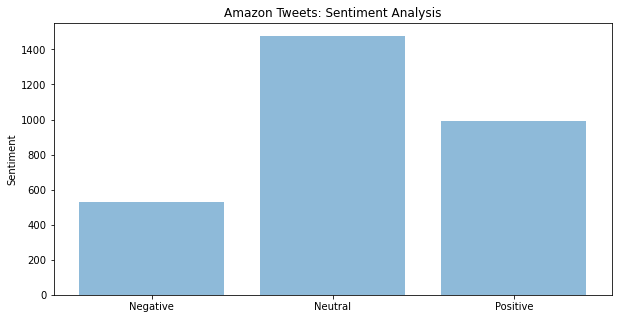

In [37]:
plt.figure(figsize=(10,5))
plt.bar(y_pos, amazon_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Amazon Tweets: Sentiment Analysis')
plt.show()

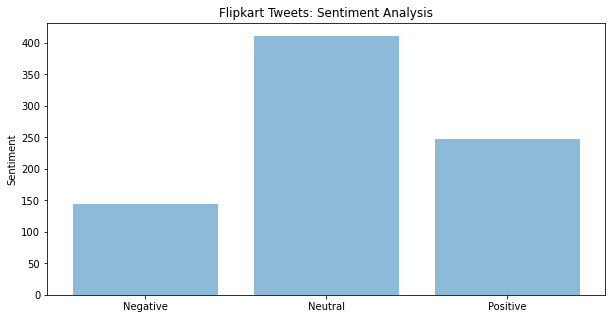

In [38]:
plt.figure(figsize=(10,5))
plt.bar(y_pos, flipkart_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Flipkart Tweets: Sentiment Analysis')
plt.show()

## Word cloud

In [39]:
# TF-IDF vectorizer
vectorizer1 = TfidfVectorizer(ngram_range=(2,2),
                             max_features=100,
                             min_df=0.01,
                             max_df=0.80)

vectorizer2 = TfidfVectorizer(ngram_range=(2,2),
                             max_features=100,
                             min_df=0.01,
                             max_df=0.80)

In [40]:
# fit the vectorizer
vectorizer1.fit_transform(amazon_tweets_df['clean_tweets'])
vectorizer2.fit_transform(flipkart_tweets_df['clean_tweets'])

<803x44 sparse matrix of type '<class 'numpy.float64'>'
	with 946 stored elements in Compressed Sparse Row format>

In [41]:
# build a word cloud of top 25 words from amazon tweets

top_n= 25
indices = vectorizer1.idf_.argsort()[::-1] # sort by TF-IDF
features = vectorizer1.get_feature_names() # word list
top_features = [(features[i], vectorizer1.idf_[i],i)
               for i in indices[:top_n]]

d1 = {}
for i in top_features:
    d1[i[0]] = i[1]
    
w1 = WordCloud(background_color='white',
             max_words=200,
             max_font_size=200,
             height=2000,
             width=2000,
             colormap='rainbow').fit_words(d1)

w1.to_file('amazonIN_tweets.png')

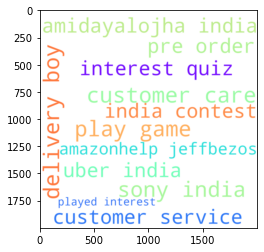

In [42]:
plt.imshow(w1, interpolation='bilinear')

In [ ]:
# build a word cloud of top 25 words from flipkart tweets

#top_n= 25
indices = vectorizer2.idf_.argsort()[::-1] # sort by TF-IDF
features = vectorizer2.get_feature_names() # word list
top_features = [(features[i], vectorizer2.idf_[i],i)
               for i in indices[:top_n]]

d2 = {}
for i in top_features:
    d2[i[0]] = i[1]
    
w2 = WordCloud(background_color='white',
             max_words=200,
             max_font_size=200,
             height=2000,
             width=2000,
             colormap='rainbow').fit_words(d2)

w2.to_file('Flipkart_tweets.png')

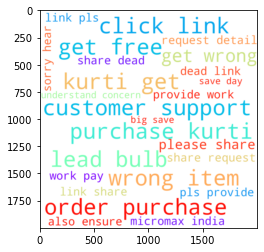

In [44]:
plt.imshow(w2, interpolation='bilinear')

## Amazon Products

In [45]:
# Tweets to be extracted for headphones purchased from amazonIN
search_words_amazon_headphones = "amazonin+headphones -filter:retweets"
t_amazon_headphones = tweepy.Cursor(api.search,
                       q = search_words_amazon_headphones,
                       lang = "en").items(3000)
amazon_headphones_tweets = [tweet.text for tweet in t_amazon_headphones]


In [46]:
# Tweets to be extracted for laptop purchased from amazonIN
search_words_amazon_laptop = "amazonin+laptop -filter:retweets"
t_amazon_laptop = tweepy.Cursor(api.search,
                       q = search_words_amazon_laptop,
                       lang = "en").items(3000)
amazon_laptop_tweets = [tweet.text for tweet in t_amazon_laptop]


In [47]:
# Tweets to be extracted for camera purchased from amazonIN
search_words_amazon_camera = "amazonin+camera -filter:retweets"
t_amazon_camera = tweepy.Cursor(api.search,
                       q = search_words_amazon_camera,
                       lang = "en").items(3000)
amazon_camera_tweets = [tweet.text for tweet in t_amazon_camera]


In [48]:
# Tweets to be extracted for shoes purchased from amazonIN
search_words_amazon_shoes = "amazonin+shoes -filter:retweets"
t_amazon_shoes = tweepy.Cursor(api.search,
                       q = search_words_amazon_shoes,
                       lang = "en").items(3000)
amazon_shoes_tweets = [tweet.text for tweet in t_amazon_shoes]


In [49]:
# Tweets to be extracted for mobile purchased from amazonIN
search_words_amazon_mobile = "amazonin+mobile -filter:retweets"
t_amazon_mobile = tweepy.Cursor(api.search,
                       q = search_words_amazon_mobile,
                       lang = "en").items(3000)
amazon_mobile_tweets = [tweet.text for tweet in t_amazon_mobile]

## Flipkart Products 

In [50]:
# Tweets to be extracted for headphones purchased from flipkart
search_words_flipkart_headphones = "flipkart+headphones -filter:retweets"
t_flipkart_headphones = tweepy.Cursor(api.search,
                       q = search_words_flipkart_headphones,
                       lang = "en").items(3000)
flipkart_headphones_tweets = [tweet.text for tweet in t_flipkart_headphones]


In [51]:
# Tweets to be extracted for laptop purchased from flipkart
search_words_flipkart_laptop = "flipkart+laptop -filter:retweets"
t_flipkart_laptop = tweepy.Cursor(api.search,
                       q = search_words_flipkart_laptop,
                       lang = "en").items(3000)
flipkart_laptop_tweets = [tweet.text for tweet in t_flipkart_laptop]


In [52]:
# Tweets to be extracted for camera purchased from flipkart
search_words_flipkart_camera = "flipkart+camera -filter:retweets"
t_flipkart_camera = tweepy.Cursor(api.search,
                       q = search_words_flipkart_camera,
                       lang = "en").items(3000)
flipkart_camera_tweets = [tweet.text for tweet in t_flipkart_camera]

In [53]:
# Tweets to be extracted for shoes purchased from flipkart
search_words_flipkart_shoes = "flipkart+shoes -filter:retweets"
t_flipkart_shoes = tweepy.Cursor(api.search,
                       q = search_words_flipkart_shoes,
                       lang = "en").items(3000)
flipkart_shoes_tweets = [tweet.text for tweet in t_flipkart_shoes]


In [54]:
# Tweets to be extracted for mobile purchased from flipkart
search_words_flipkart_mobile = "flipkart+mobile -filter:retweets"
t_flipkart_mobile = tweepy.Cursor(api.search,
                       q = search_words_flipkart_mobile,
                       lang = "en").items(3000)
flipkart_mobile_tweets = [tweet.text for tweet in t_flipkart_mobile]

In [55]:
# convert list of tweets to a dataframe

amazon_headphones_tweets_df = pd.DataFrame({'tweets' : amazon_headphones_tweets})
amazon_laptop_tweets_df = pd.DataFrame({'tweets' : amazon_laptop_tweets})
amazon_camera_tweets_df = pd.DataFrame({'tweets' : amazon_camera_tweets})
amazon_shoes_tweets_df = pd.DataFrame({'tweets' : amazon_shoes_tweets})
amazon_mobile_tweets_df = pd.DataFrame({'tweets' : amazon_mobile_tweets})

flipkart_headphones_tweets_df = pd.DataFrame({'tweets' : flipkart_headphones_tweets})
flipkart_laptop_tweets_df = pd.DataFrame({'tweets' : flipkart_laptop_tweets})
flipkart_camera_tweets_df = pd.DataFrame({'tweets' : flipkart_camera_tweets})
flipkart_shoes_tweets_df = pd.DataFrame({'tweets' : flipkart_shoes_tweets})
flipkart_mobile_tweets_df = pd.DataFrame({'tweets' : flipkart_mobile_tweets})


In [57]:
amazon_headphones_tweets_df['clean_tweets'] = amazon_headphones_tweets_df['tweets'].apply(cleanse)
amazon_headphones_tweets_df['clean_tweets'] = amazon_headphones_tweets_df['clean_tweets'].apply(lemmatize)

amazon_laptop_tweets_df['clean_tweets'] = amazon_laptop_tweets_df['tweets'].apply(cleanse)
amazon_laptop_tweets_df['clean_tweets'] = amazon_laptop_tweets_df['clean_tweets'].apply(lemmatize)

amazon_camera_tweets_df['clean_tweets'] = amazon_camera_tweets_df['tweets'].apply(cleanse)
amazon_camera_tweets_df['clean_tweets'] = amazon_camera_tweets_df['clean_tweets'].apply(lemmatize)

amazon_shoes_tweets_df['clean_tweets'] = amazon_shoes_tweets_df['tweets'].apply(cleanse)
amazon_shoes_tweets_df['clean_tweets'] = amazon_shoes_tweets_df['clean_tweets'].apply(lemmatize)

amazon_mobile_tweets_df['clean_tweets'] = amazon_mobile_tweets_df['tweets'].apply(cleanse)
amazon_mobile_tweets_df['clean_tweets'] = amazon_mobile_tweets_df['clean_tweets'].apply(lemmatize)


In [58]:
flipkart_headphones_tweets_df['clean_tweets'] = flipkart_headphones_tweets_df['tweets'].apply(cleanse)
flipkart_headphones_tweets_df['clean_tweets'] = flipkart_headphones_tweets_df['clean_tweets'].apply(lemmatize)

flipkart_laptop_tweets_df['clean_tweets'] = flipkart_laptop_tweets_df['tweets'].apply(cleanse)
flipkart_laptop_tweets_df['clean_tweets'] = flipkart_laptop_tweets_df['clean_tweets'].apply(lemmatize)

flipkart_camera_tweets_df['clean_tweets'] = flipkart_camera_tweets_df['tweets'].apply(cleanse)
flipkart_camera_tweets_df['clean_tweets'] = flipkart_camera_tweets_df['clean_tweets'].apply(lemmatize)

flipkart_shoes_tweets_df['clean_tweets'] = flipkart_shoes_tweets_df['tweets'].apply(cleanse)
flipkart_shoes_tweets_df['clean_tweets'] = flipkart_shoes_tweets_df['clean_tweets'].apply(lemmatize)

flipkart_mobile_tweets_df['clean_tweets'] = flipkart_mobile_tweets_df['tweets'].apply(cleanse)
flipkart_mobile_tweets_df['clean_tweets'] = flipkart_mobile_tweets_df['clean_tweets'].apply(lemmatize)


In [60]:
amazon_headphones_tweets_df['sentiment'] = amazon_headphones_tweets_df['clean_tweets'].apply(get_sentiment)
amazon_laptop_tweets_df['sentiment'] = amazon_laptop_tweets_df['clean_tweets'].apply(get_sentiment)
amazon_camera_tweets_df['sentiment'] = amazon_camera_tweets_df['clean_tweets'].apply(get_sentiment)
amazon_shoes_tweets_df['sentiment'] = amazon_shoes_tweets_df['clean_tweets'].apply(get_sentiment)
amazon_mobile_tweets_df['sentiment'] = amazon_mobile_tweets_df['clean_tweets'].apply(get_sentiment)

flipkart_headphones_tweets_df['sentiment'] = flipkart_headphones_tweets_df['clean_tweets'].apply(get_sentiment)
flipkart_laptop_tweets_df['sentiment'] = flipkart_laptop_tweets_df['clean_tweets'].apply(get_sentiment)
flipkart_camera_tweets_df['sentiment'] = flipkart_camera_tweets_df['clean_tweets'].apply(get_sentiment)
flipkart_shoes_tweets_df['sentiment'] = flipkart_shoes_tweets_df['clean_tweets'].apply(get_sentiment)
flipkart_mobile_tweets_df['sentiment'] = flipkart_mobile_tweets_df['clean_tweets'].apply(get_sentiment)


In [61]:
AH_negative_counts = amazon_headphones_tweets_df[amazon_headphones_tweets_df['sentiment']<0].count()[0]
AH_neutral_counts = amazon_headphones_tweets_df[amazon_headphones_tweets_df['sentiment']==0].count()[0]
AH_positive_counts = amazon_headphones_tweets_df[amazon_headphones_tweets_df['sentiment']>0].count()[0]

AL_negative_counts = amazon_laptop_tweets_df[amazon_laptop_tweets_df['sentiment']<0].count()[0]
AL_neutral_counts = amazon_laptop_tweets_df[amazon_laptop_tweets_df['sentiment']==0].count()[0]
AL_positive_counts = amazon_laptop_tweets_df[amazon_laptop_tweets_df['sentiment']>0].count()[0]

AC_negative_counts = amazon_camera_tweets_df[amazon_camera_tweets_df['sentiment']<0].count()[0]
AC_neutral_counts = amazon_camera_tweets_df[amazon_camera_tweets_df['sentiment']==0].count()[0]
AC_positive_counts = amazon_camera_tweets_df[amazon_camera_tweets_df['sentiment']>0].count()[0]

AS_negative_counts = amazon_shoes_tweets_df[amazon_shoes_tweets_df['sentiment']<0].count()[0]
AS_neutral_counts = amazon_shoes_tweets_df[amazon_shoes_tweets_df['sentiment']==0].count()[0]
AS_positive_counts = amazon_shoes_tweets_df[amazon_shoes_tweets_df['sentiment']>0].count()[0]

AM_negative_counts = amazon_mobile_tweets_df[amazon_mobile_tweets_df['sentiment']<0].count()[0]
AM_neutral_counts = amazon_mobile_tweets_df[amazon_mobile_tweets_df['sentiment']==0].count()[0]
AM_positive_counts = amazon_mobile_tweets_df[amazon_mobile_tweets_df['sentiment']>0].count()[0]

In [63]:
FH_negative_counts = flipkart_headphones_tweets_df[flipkart_headphones_tweets_df['sentiment']<0].count()[0]
FH_neutral_counts = flipkart_headphones_tweets_df[flipkart_headphones_tweets_df['sentiment']==0].count()[0]
FH_positive_counts = flipkart_headphones_tweets_df[flipkart_headphones_tweets_df['sentiment']>0].count()[0]

FL_negative_counts = flipkart_laptop_tweets_df[flipkart_laptop_tweets_df['sentiment']<0].count()[0]
FL_neutral_counts = flipkart_laptop_tweets_df[flipkart_laptop_tweets_df['sentiment']==0].count()[0]
FL_positive_counts = flipkart_laptop_tweets_df[flipkart_laptop_tweets_df['sentiment']>0].count()[0]

FC_negative_counts = flipkart_camera_tweets_df[flipkart_camera_tweets_df['sentiment']<0].count()[0]
FC_neutral_counts = flipkart_camera_tweets_df[flipkart_camera_tweets_df['sentiment']==0].count()[0]
FC_positive_counts = flipkart_camera_tweets_df[flipkart_camera_tweets_df['sentiment']>0].count()[0]

FS_negative_counts = flipkart_shoes_tweets_df[flipkart_shoes_tweets_df['sentiment']<0].count()[0]
FS_neutral_counts = flipkart_shoes_tweets_df[flipkart_shoes_tweets_df['sentiment']==0].count()[0]
FS_positive_counts = flipkart_shoes_tweets_df[flipkart_shoes_tweets_df['sentiment']>0].count()[0]

FM_negative_counts = flipkart_mobile_tweets_df[flipkart_mobile_tweets_df['sentiment']<0].count()[0]
FM_neutral_counts = flipkart_mobile_tweets_df[flipkart_mobile_tweets_df['sentiment']==0].count()[0]
FM_positive_counts = flipkart_mobile_tweets_df[flipkart_mobile_tweets_df['sentiment']>0].count()[0]

In [64]:
y_pos = [0,1,2]

AH_counts = [AH_negative_counts, AH_neutral_counts, AH_positive_counts]
AL_counts = [AL_negative_counts, AL_neutral_counts, AL_positive_counts]
AC_counts = [AC_negative_counts, AC_neutral_counts, AC_positive_counts]
AS_counts = [AS_negative_counts, AS_neutral_counts, AS_positive_counts]
AM_counts = [AM_negative_counts, AM_neutral_counts, AM_positive_counts]

FH_counts = [FH_negative_counts, FH_neutral_counts, FH_positive_counts]
FL_counts = [FL_negative_counts, FL_neutral_counts, FL_positive_counts]
FC_counts = [FC_negative_counts, FC_neutral_counts, FC_positive_counts]
FS_counts = [FS_negative_counts, FS_neutral_counts, FS_positive_counts]
FM_counts = [FM_negative_counts, FM_neutral_counts, FM_positive_counts]

In [65]:
# Amazon counts
print(AH_counts)
print(AL_counts)
print(AC_counts)
print(AS_counts)
print(AM_counts)

[2, 2, 8]
[10, 28, 29]
[16, 30, 36]
[2, 7, 13]
[28, 65, 58]


In [66]:
#Flipkart Counts
print(FH_counts)
print(FL_counts)
print(FC_counts)
print(FS_counts)
print(FM_counts)

[5, 8, 5]
[24, 83, 23]
[5, 120, 15]
[12, 51, 29]
[42, 391, 102]


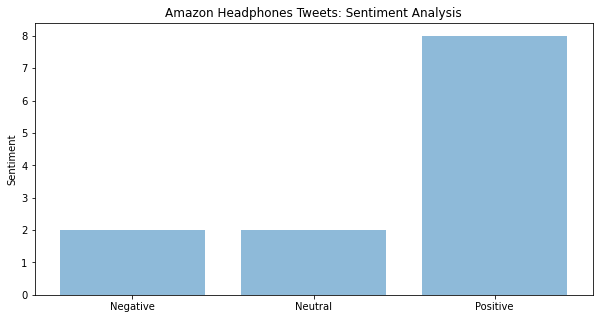

In [67]:
# plot amazon headphones tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, AH_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Amazon Headphones Tweets: Sentiment Analysis')
plt.show()

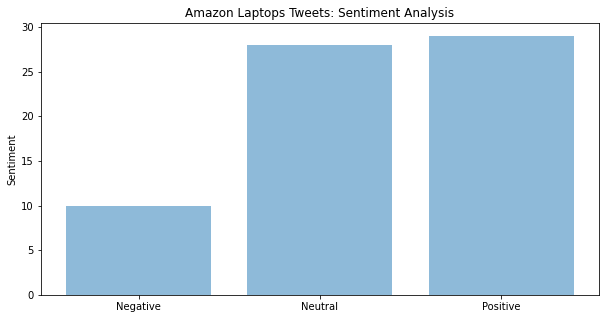

In [68]:
# plot amazon laptops tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, AL_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Amazon Laptops Tweets: Sentiment Analysis')
plt.show()

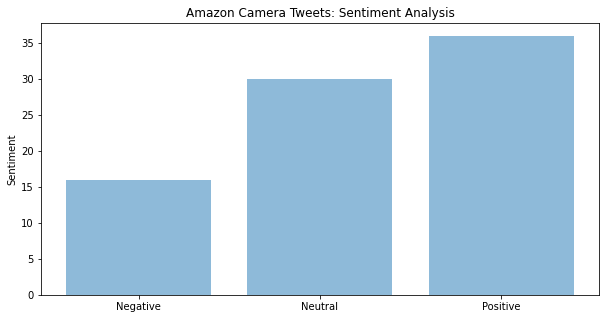

In [69]:
# plot Amazon Camera tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, AC_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Amazon Camera Tweets: Sentiment Analysis')
plt.show()

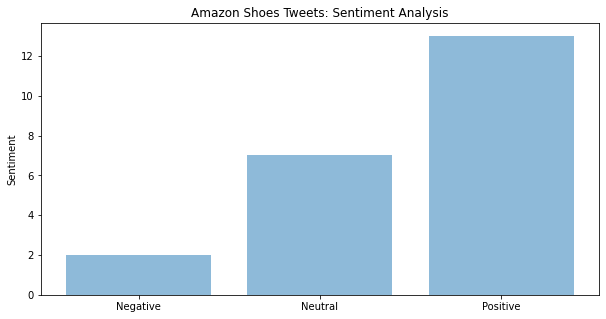

In [70]:
# plot Amazon Shoes Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, AS_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Amazon Shoes Tweets: Sentiment Analysis')
plt.show()

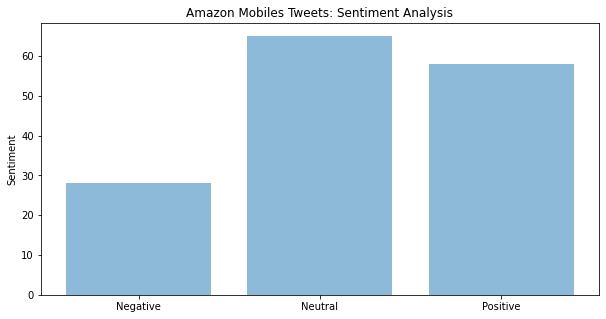

In [71]:
# plot Amazon Mobile Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, AM_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Amazon Mobiles Tweets: Sentiment Analysis')
plt.show()

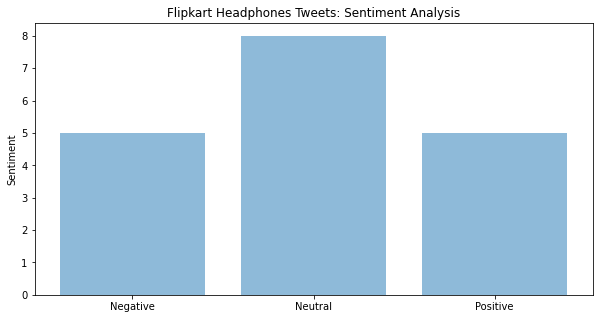

In [72]:
# plot Flipkart headphones Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, FH_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Flipkart Headphones Tweets: Sentiment Analysis')
plt.show()

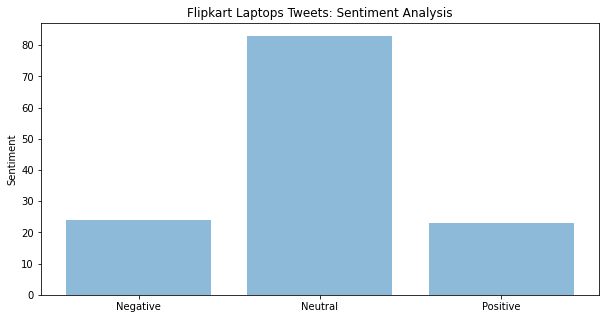

In [73]:
# plot Flipkart Laptops Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, FL_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Flipkart Laptops Tweets: Sentiment Analysis')
plt.show()

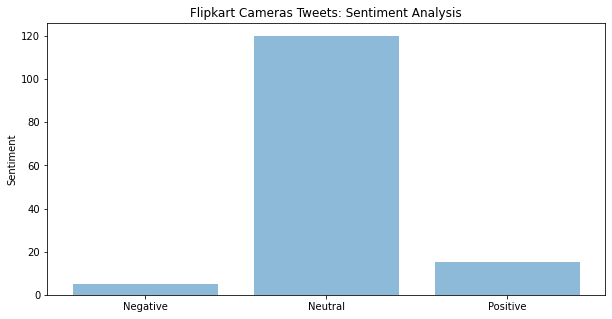

In [74]:
# plot Flipkart Cameras Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, FC_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Flipkart Cameras Tweets: Sentiment Analysis')
plt.show()

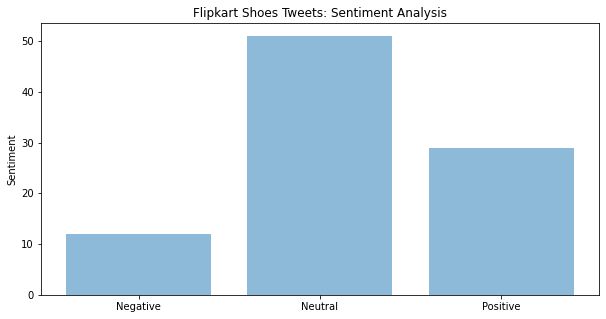

In [76]:
# plot Flipkart Shoes Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, FS_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Flipkart Shoes Tweets: Sentiment Analysis')
plt.show()

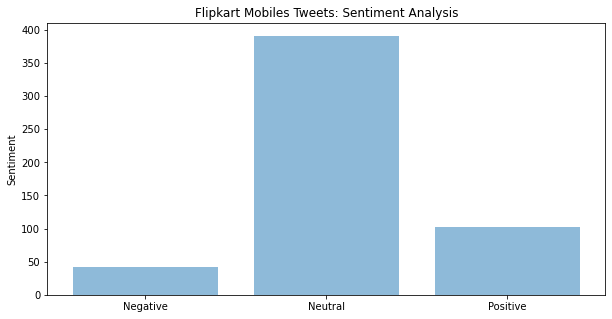

In [77]:
# plot Flipkart Mobiles Tweets
plt.figure(figsize=(10,5))
plt.bar(y_pos, FM_counts, align='center', alpha=0.5)
plt.xticks(y_pos,['Negative','Neutral','Positive'])
plt.ylabel('Sentiment')
plt.title('Flipkart Mobiles Tweets: Sentiment Analysis')
plt.show()